## Getting Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [5]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [6]:
!kaggle competitions download -c how-much-did-it-rain-ii

  0% 0.00/4.40M [00:00<?, ?B/s]
100% 4.40M/4.40M [00:00<00:00, 69.1MB/s]
  0% 0.00/1.96k [00:00<?, ?B/s]
100% 1.96k/1.96k [00:00<00:00, 277kB/s]
 96% 129M/135M [00:02<00:00, 78.4MB/s]
100% 135M/135M [00:02<00:00, 57.1MB/s]
 96% 232M/240M [00:01<00:00, 158MB/s]
100% 240M/240M [00:01<00:00, 142MB/s]


In [7]:
%ls

kaggle.json  sample_dask.py  sample_solution.csv.zip  test.zip  train.zip


In [8]:
!unzip \*.zip  && rm *.zip

Archive:  sample_solution.csv.zip
  inflating: sample_solution.csv     

Archive:  test.zip
  inflating: test.csv                

Archive:  train.zip
  inflating: train.csv               

3 archives were successfully processed.


In [9]:
%mkdir rain_time_series
%mv sample_dask.py sample_solution.csv test.csv train.csv ./rain_time_series

In [10]:
%cd rain_time_series/

/content/drive/My Drive/Kaggle/rain_time_series


## EDA

In [2]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train[train.columns[0]] = train[train.columns[0]].astype(np.int32)
train[train.columns[1:]] = train[train.columns[1:]].astype(np.float32)

In [3]:
train.head()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,1,25.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
3,1,35.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
4,1,45.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254


In [4]:
train[train.Id == 3]

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
18,3,4.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014
19,3,9.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014
20,3,14.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014
21,3,18.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014
22,3,23.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014
23,3,28.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014
24,3,33.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014
25,3,38.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014
26,3,43.0,10.0,NaN,NaN,NaN,8.5,NaN,NaN,NaN,8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014
27,3,48.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.162014


In [5]:
ref_present = train[train.Ref.notna()==True]['Id'].unique()
train = train[train['Id'].isin(ref_present)]

In [6]:
len(train)

9125329

In [7]:
train.isna().sum()

Id                             0
minutes_past                   0
radardist_km                   0
Ref                      2775954
Ref_5x5_10th             3841387
Ref_5x5_50th             2772390
Ref_5x5_90th             1706556
RefComposite             2429475
RefComposite_5x5_10th    3377843
RefComposite_5x5_50th    2434061
RefComposite_5x5_90th    1471489
RhoHV                    4314082
RhoHV_5x5_10th           5052173
RhoHV_5x5_50th           4300572
RhoHV_5x5_90th           3458417
Zdr                      4314082
Zdr_5x5_10th             5052173
Zdr_5x5_50th             4300572
Zdr_5x5_90th             3458417
Kdp                      5036548
Kdp_5x5_10th             5745822
Kdp_5x5_50th             5026320
Kdp_5x5_90th             4231865
Expected                       0
dtype: int64

**Imputation**

In [8]:
columns_toimpute = train.iloc[:,3:-1].columns.tolist()
train.fillna(train.groupby(['Id'])[columns_toimpute].transform('mean'), inplace=True)
train.fillna(0.0, inplace=True)
train.reset_index(drop=True, inplace=True)
train.isna().sum()

Id                       0
minutes_past             0
radardist_km             0
Ref                      0
Ref_5x5_10th             0
Ref_5x5_50th             0
Ref_5x5_90th             0
RefComposite             0
RefComposite_5x5_10th    0
RefComposite_5x5_50th    0
RefComposite_5x5_90th    0
RhoHV                    0
RhoHV_5x5_10th           0
RhoHV_5x5_50th           0
RhoHV_5x5_90th           0
Zdr                      0
Zdr_5x5_10th             0
Zdr_5x5_50th             0
Zdr_5x5_90th             0
Kdp                      0
Kdp_5x5_10th             0
Kdp_5x5_50th             0
Kdp_5x5_90th             0
Expected                 0
dtype: int64

In [9]:
print(f'Mean Expected {np.mean(train.Expected)}')
print(f'Max Expected {np.max(train.Expected)}')

Mean Expected 22.431513292076517
Max Expected 33017.73046875


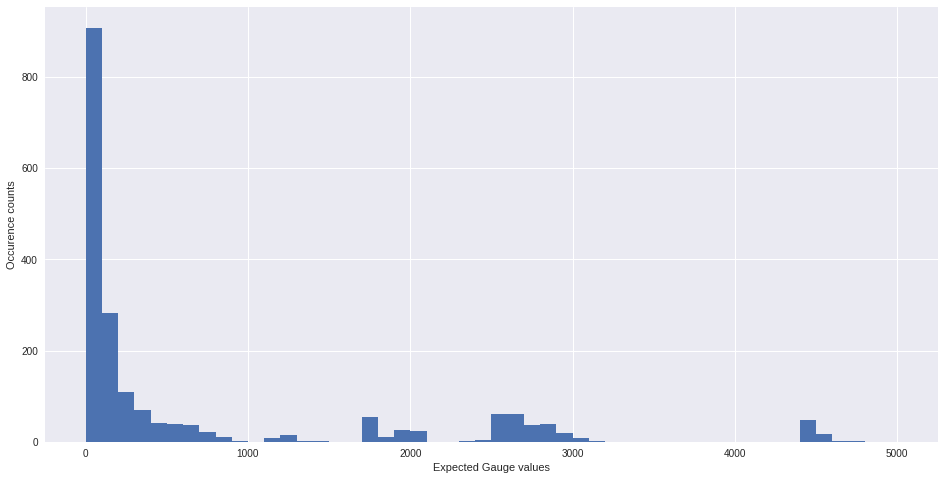

In [10]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.figure(figsize=(16,8))
bins = list(range(0,5100,100))
plt.hist(train.Expected.unique(), bins=bins)
plt.xlabel('Expected Gauge values')
plt.ylabel('Occurence counts')
plt.show()

In [11]:
# As there are a lot of outliers for expected gauge value, I decided on keeping a threshold of 70.
threshold = 70.0
train = train[train.Expected <= threshold]
len(train)

8914175

**Train Data Transform**

In [12]:
num_feat = 22
train_groups = train.groupby("Id")
train_size = len(train_groups)
max_seq = train_groups.size().max()
max_seq

19

In [ ]:
X_train = np.zeros((train_size, max_seq, num_feat), dtype=np.float32)
y_train = np.zeros(train_size, dtype=np.float32)

i = 0
for _, group in train_groups:
    if i%10000 == 0:
      print(i)
    X = group.values
    seq_len = X.shape[0]
    X_train[i,:seq_len,:] = X[:,1:23]
    y_train[i] = X[0,23]
    i += 1
    del X
    
del train_groups

In [14]:
X_train.shape, y_train.shape

((713894, 19, 22), (713894,))

## Modeling

In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Flatten, Input, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Nadam

input = Input((X_train.shape[1], X_train.shape[2]))
m = Dense(8)(input)
m = Bidirectional(LSTM(64,return_sequences=True))(m)
m = TimeDistributed(Dense(32))(m)

m = Dropout(0.3)(m)
m = Dense(1)(m)

model = Model(input, m)

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=5)
model_ckp = ModelCheckpoint('best_model.h5',
                            save_best_only=True,
                            monitor='val_loss',
                            mode='auto')

model.compile(loss='mae',
              optimizer=Nadam(lr=0.001))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 19, 22)]          0         
_________________________________________________________________
dense_4 (Dense)              (None, 19, 8)             184       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 19, 128)           37376     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 19, 32)            4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 19, 1)             33        
Total params: 41,721
Trainable params: 41,721
Non-trainable params: 0
_______________________________________________________

In [16]:
X_train.shape[1], X_train.shape[2]

(19, 22)

In [19]:
model.fit(X_train, y_train, 
         batch_size=256,
         epochs=30, 
         validation_split=0.2,
         callbacks=[es, model_ckp])

Epoch 1/30
2231/2231 [==============================] - 178s 78ms/step - loss: 2.4737 - val_loss: 2.3991
Epoch 2/30
2231/2231 [==============================] - 171s 77ms/step - loss: 2.3280 - val_loss: 2.3888
Epoch 3/30
2231/2231 [==============================] - 171s 76ms/step - loss: 2.2850 - val_loss: 2.3600
Epoch 4/30
2231/2231 [==============================] - 174s 78ms/step - loss: 2.2960 - val_loss: 2.3682
Epoch 5/30
2231/2231 [==============================] - 175s 78ms/step - loss: 2.2683 - val_loss: 2.3528
Epoch 6/30
2231/2231 [==============================] - 179s 80ms/step - loss: 2.2670 - val_loss: 2.3437
Epoch 7/30
2231/2231 [==============================] - 179s 80ms/step - loss: 2.2799 - val_loss: 2.3527
Epoch 8/30
2231/2231 [==============================] - 172s 77ms/step - loss: 2.2431 - val_loss: 2.3412
Epoch 9/30
2231/2231 [==============================] - 183s 82ms/step - loss: 2.2691 - val_loss: 2.3430
Epoch 10/30
2231/2231 [==============================] 